### IMU preintegration from scratch and evaluation on KITTI/EuRoC dataset

Author: Jongwon Lee
Date: April 23rd, 2024


Do all imports

In [1]:
import numpy as np
from scipy.linalg import expm, logm
from scipy.spatial.transform import Rotation as R
from pathlib import Path
import matplotlib.pyplot as plt

import utils, imu_preintegration

Read data

In [2]:
# Specify the dataset (should be 'kitti' or 'euroc')
chosen_dataset = 'kitti'

assert(chosen_dataset in ['kitti', 'euroc'])

Provide settings

In [3]:
if chosen_dataset == 'euroc': # Note: euroc takes a bit longer to load.
    # Use EuRoC MAV
    
    # MAV video folder
    mav_video_folder = Path('./data/mav0')


    # Read MAV data
    dataset_info = utils.read_data_mav(mav_video_folder)
    print("Read dataset with keys: {}".format(sorted(list(dataset_info.keys()))))

    # Extract relevant data
    cam0_K = dataset_info['cam0_K']
    cam0_distortion = dataset_info['cam0_distortion']
    visual_inertial_data = dataset_info['visual_inertial_data']

    sigma_acc_wn = dataset_info['imu_accelerometer_noise_density']
    sigma_gyr_wn = dataset_info['imu_gyroscope_noise_density']
    sigma_acc_rw = dataset_info['imu_accelerometer_noise_density']
    sigma_gyr_rw = dataset_info['imu_gyroscope_random_walk']

    dt = 1/200 # IMU frequency

    # Get extrinsics
    T_inB_ofC = dataset_info['cam0_extrinsics']
    T_inC_ofB = np.block([[T_inB_ofC[:3,:3].T, (-T_inB_ofC[:3,:3].T @ T_inB_ofC[:3,-1])[:,np.newaxis]], [np.zeros(3), 1]])

    # Collate
    acc_meas, gyr_meas = utils.imu_collate(dataset_info['visual_inertial_data'])
    R_inR_ofB, v_inR_ofB, p_inR_ofB, b_a, b_w = utils.groundtruth_collate(dataset_info['visual_inertial_data'], True)

    # As EuRoC's ground-truth (MoCap) is not aligned with gravity (i.e., in world frame), we identify the orientation of MoCap frame in world frame
    gravity = np.array([0., 0., -9.81])

    g_inB = - np.mean(acc_meas[:10], axis=0)
    g_inW = gravity

    def align_vectors(g_inB, g_inW):
        # Normalize input vectors
        g_inB_unit = g_inB / np.linalg.norm(g_inB)
        g_inW_unit = g_inW / np.linalg.norm(g_inW)

        # Compute the axis of rotation
        v = np.cross(g_inB_unit, g_inW_unit)

        # Compute the angle of rotation
        cos_theta = np.dot(g_inB_unit, g_inW_unit)
        sin_theta = np.linalg.norm(v)
        theta = np.arctan2(sin_theta, cos_theta)

        v /= np.linalg.norm(v)
        
        # Compute the rotation matrix
        Rot = R.from_rotvec(theta*v)
        return Rot

    # Compute rotation matrix
    R_inW_ofB = align_vectors(g_inB, g_inW)
    print("Rotation Matrix:\n", R_inW_ofB.as_matrix())

    R_inW_ofB.apply(g_inB)

    R_inW_ofR = R_inW_ofB * R_inR_ofB[:10].mean().inv()
    R_inW_ofB = R_inW_ofR * R_inR_ofB
    v_inW_ofB = R_inW_ofR.apply(v_inR_ofB)
    p_inW_ofB = R_inW_ofR.apply(p_inR_ofB)
else:
    # Use KITTI
    kitti_base_path = './data/kitti'
    kitti_date = '2011_09_26'
    kitti_drive = '0022'

    gravity = np.array([0., 0., -9.81])

    # Read KITTI data
    dataset_info = utils.read_data_kitti(kitti_base_path, kitti_date, kitti_drive)

    # Extract relevant data
    cam0_K = dataset_info['cam0_K']
    cam0_distortion = dataset_info['cam0_distortion']
    visual_inertial_data = dataset_info['visual_inertial_data']

    T_inC_ofB = dataset_info['cam0_extrinsics']
    R_inB_of_C = T_inC_ofB[:3, :3].T
    t_inB_of_C = R_inB_of_C @ T_inC_ofB[:3, 3]
    T_inB_ofC = np.block([[R_inB_of_C, t_inB_of_C[:,np.newaxis]], [np.zeros(3), 1]])

    sigma_acc_wn = 1e-4  # accelerometer white noise sigma
    sigma_gyr_wn = 1e-6  # gyroscope white noise sigma
    sigma_acc_rw = 1e-5  # accelerometer random walk sigma
    sigma_gyr_rw = 1e-7  # gyroscope random walk sigma

    # KITTI has data at 10 Hz
    dt = 0.1

    # Collate
    acc_meas, gyr_meas = utils.imu_collate(visual_inertial_data)
    R_inW_ofB, v_inW_ofB, p_inW_ofB, b_a, b_w = utils.groundtruth_collate(visual_inertial_data, False)

Create random generator

In [4]:
rng = utils.create_rng(42)

seeding RNG with 42


Define `Preintegrator` class

In [5]:
# Define IMU preintegrator
Cov_acc_bias = sigma_acc_rw ** 2  * dt
Cov_gyr_bias = sigma_gyr_rw ** 2  * dt

integrator = imu_preintegration.Preintegrator(dt, sigma_acc_wn**2, sigma_gyr_wn**2, b_a[0], b_w[0])        

Perform preintegration

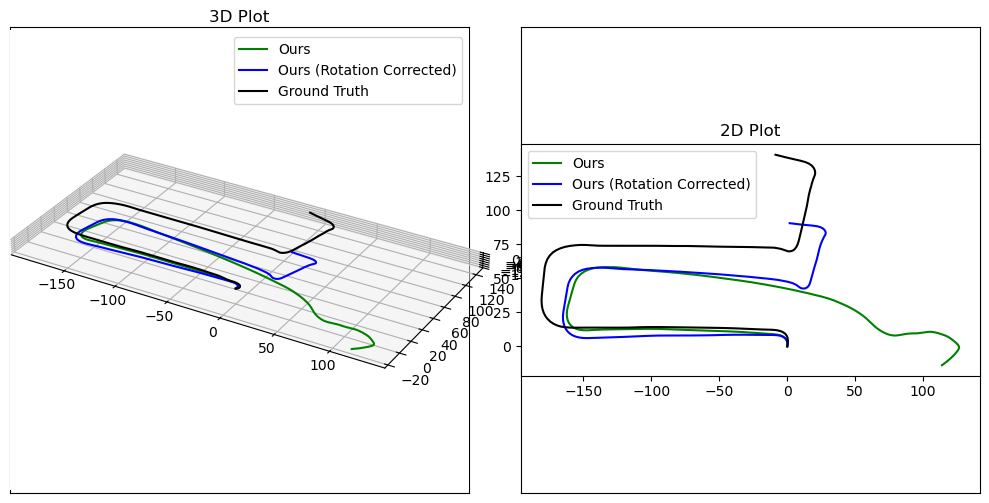

In [6]:
steps = 5
idxs = range(0, len(visual_inertial_data), steps)

# Initialize position, velocity, and rotation for ground truth and predictions
pos_gt, pos, pos_corrected = [p_inW_ofB[0]], [p_inW_ofB[0]], [p_inW_ofB[0]]
vel_gt, vel, vel_corrected = [v_inW_ofB[0]], [v_inW_ofB[0]], [v_inW_ofB[0]]
rot_gt, rot, rot_corrected = [R_inW_ofB[0].as_matrix()], [R_inW_ofB[0].as_matrix()], [R_inW_ofB[0].as_matrix()]

# Data integration loop
for i, j in zip(idxs, idxs[1:]):
    dt_ij = dt * (j-i)
    dR, dv, dp, Sigma = integrator.integrate(acc_meas=acc_meas[i:j], gyr_meas=gyr_meas[i:j])
    
    # Update corrected estimates
    rot_corrected_curr = rot_gt[-1] @ dR
    vel_corrected_curr = vel_corrected[-1] + gravity * dt_ij + rot_gt[-1] @ dv
    pos_corrected_curr = pos_corrected[-1] + vel_corrected[-1] * dt_ij + 0.5 * gravity * dt_ij**2 + rot_gt[-1] @ dp
    
    pos_corrected.append(pos_corrected_curr)
    vel_corrected.append(vel_corrected_curr)
    rot_corrected.append(rot_corrected_curr)

    # Update uncorrected estimates
    rot_curr = rot[-1] @ dR
    vel_curr = vel[-1] + gravity * dt_ij + rot[-1] @ dv
    pos_curr = pos[-1] + vel[-1] * dt_ij + 0.5 * gravity * dt_ij**2 + rot[-1] @ dp
    
    pos.append(pos_curr)
    vel.append(vel_curr)
    rot.append(rot_curr)

    # Update ground truth
    pos_gt.append(p_inW_ofB[j])
    vel_gt.append(v_inW_ofB[j])
    rot_gt.append(R_inW_ofB[j].as_matrix())

# Convert lists to numpy arrays
pos_gt, pos, pos_corrected = np.array(pos_gt), np.array(pos), np.array(pos_corrected)
vel_gt, vel, vel_corrected = np.array(vel_gt), np.array(vel), np.array(vel_corrected)
rot_gt, rot, rot_corrected = np.array(rot_gt), np.array(rot), np.array(rot_corrected)

# Visualization of results in 2D and 3D plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])

# 3D and 2D plots
ax3d = fig.add_subplot(121, projection='3d')
ax3d.plot3D(pos[:, 0], pos[:, 1], pos[:, 2], 'g', label='Ours')
ax3d.plot3D(pos_corrected[:, 0], pos_corrected[:, 1], pos_corrected[:, 2], 'b', label='Ours (Rotation Corrected)')
ax3d.plot3D(pos_gt[:, 0], pos_gt[:, 1], pos_gt[:, 2], 'k', label='Ground Truth')
ax3d.legend()
ax3d.set_title('3D Plot')
ax3d.set_aspect('equal')

ax2d = fig.add_subplot(122)
ax2d.plot(pos[:, 0], pos[:, 1], 'g', label='Ours')
ax2d.plot(pos_corrected[:, 0], pos_corrected[:, 1], 'b', label='Ours (Rotation Corrected)')
ax2d.plot(pos_gt[:, 0], pos_gt[:, 1], 'k', label='Ground Truth')
ax2d.legend()
ax2d.set_title('2D Plot')
ax2d.set_aspect('equal')

plt.tight_layout()
plt.show()